# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
len(X_train), len(y_train), len(X_test), len(y_test)

(50000, 50000, 10000, 10000)

In [4]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=42)

In [5]:
len(X_train), len(y_train), len(X_val), len(y_val)

(45000, 45000, 5000, 5000)

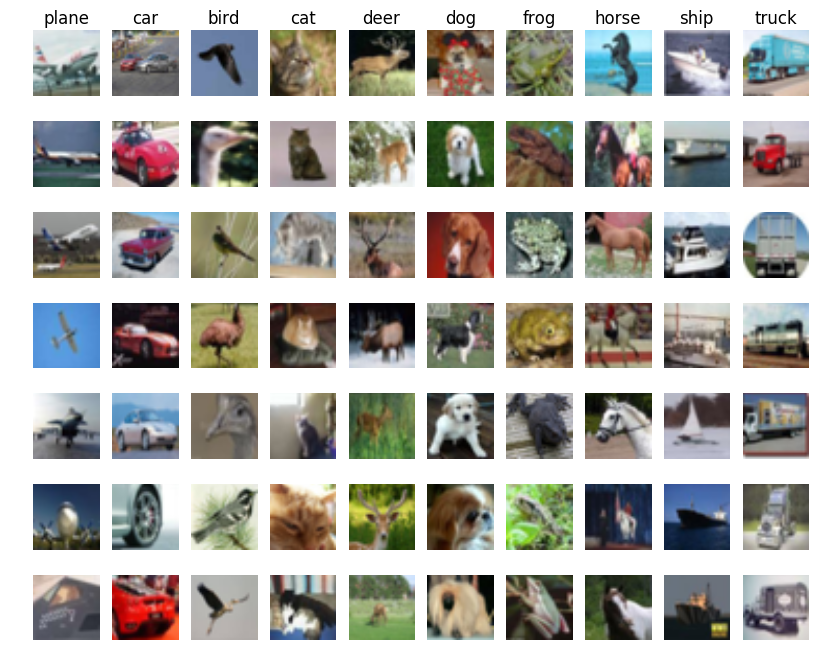

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
import lasagne
import theano
from theano import tensor as T

#theano.config.optimizer='fast_compile'
theano.config.optimizer='None'


#theano.config.exception_verbosity='high'
#theano.config.compute_test_value = 'warn'

from lasagne.nonlinearities import *

from lasagne.layers import Conv2DLayer, DropoutLayer, DenseLayer, MaxPool2DLayer
from lasagne.init import GlorotUniform

In [8]:
X_train.shape, X_test.shape, X_val.shape

((45000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

In [9]:
X_train = np.array([t.transpose() for t in X_train])
X_test = np.array([t.transpose() for t in X_test])
X_val = np.array([t.transpose() for t in X_val])


In [10]:
X_train.shape, X_test.shape, X_val.shape

((45000, 3, 32, 32), (10000, 3, 32, 32), (5000, 3, 32, 32))

In [11]:
input_X = T.tensor4("X")

target_y = T.vector("target Y integer", dtype='int32')

In [12]:
input_X.shape, target_y.shape

(Shape.0, Shape.0)

Так задаётся архитектура нейронки

In [13]:
input_layer = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)




#nnet = <сверочная нейросеть>

network = input_layer

#network = Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=sigmoid, W=GlorotUniform())

#network = MaxPool2DLayer(network, pool_size=(2, 2))

#network = Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=sigmoid)
    
#network = MaxPool2DLayer(network, pool_size=(2, 2))

#network = DropoutLayer(network, p=.5)

network = DenseLayer(network, num_units=256, nonlinearity=sigmoid)

#network = DropoutLayer(network, p=.5)

network = DenseLayer(network, num_units=256, nonlinearity=sigmoid)

network = DenseLayer(network, num_units=256, nonlinearity=sigmoid)

   
nnet = network





# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf

dense_output = lasagne.layers.DenseLayer(nnet, num_units = 10, nonlinearity=softmax)

In [14]:
lasagne.layers.get_all_layers(dense_output)

In [15]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [16]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [17]:
#loss = <функция потерь>
#accuracy = <njxyjcnm>



loss = lasagne.objectives.binary_crossentropy(y_predicted, target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()



In [18]:
#train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=<оптимизатор>)

updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.01)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd, allow_input_downcast=True)



accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)

In [19]:
lasagne.layers.count_params(dense_output)

920842

In [20]:
train_fun

### Вот и всё, пошли её учить

In [21]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [22]:
X_train.shape, y_train.shape

((45000, 3, 32, 32), (45000,))

In [23]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [24]:
y_train

array([3, 1, 0, ..., 8, 8, 8])

In [25]:
train_fun

In [31]:
batch_size = 2
for batch in iterate_minibatches(X_train, y_train, batch_size):
    inputs, targets = batch

In [32]:
inputs.shape, targets.shape

((2, 3, 32, 32), (2,))

In [35]:
targets

array([8, 8])

In [36]:
train_fun(inputs, targets)

ValueError: Input dimension mis-match. (input[0].shape[1] = 2, input[1].shape[1] = 10)
Apply node that caused the error: Elemwise{mul,no_inplace}(InplaceDimShuffle{x,0}.0, Elemwise{log,no_inplace}.0)
Toposort index: 59
Inputs types: [TensorType(int32, row), TensorType(float64, matrix)]
Inputs shapes: [(1, 2), (2, 10)]
Inputs strides: [(8, 4), (80, 8)]
Inputs values: [array([[8, 8]], dtype=int32), 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-fc542d3c41aa>", line 6, in <module>
    loss = lasagne.objectives.binary_crossentropy(y_predicted, target_y).mean()
  File "/home/user/anaconda2/lib/python2.7/site-packages/lasagne/objectives.py", line 116, in binary_crossentropy
    return theano.tensor.nnet.binary_crossentropy(predictions, targets)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [46]:
for batch in iterate_minibatches(X_train, y_train, batch_size):
    inputs, targets = batch
    train_err_batch, train_acc_batch = train_fun(inputs, targets)

ValueError: Input dimension mis-match. (input[0].shape[1] = 2, input[1].shape[1] = 10)
Apply node that caused the error: Elemwise{mul,no_inplace}(InplaceDimShuffle{x,0}.0, Elemwise{log,no_inplace}.0)
Toposort index: 35
Inputs types: [TensorType(int32, row), TensorType(float64, matrix)]
Inputs shapes: [(1, 2), (2, 10)]
Inputs strides: [(8, 4), (80, 8)]
Inputs values: [array([[3, 1]], dtype=int32), 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-fc542d3c41aa>", line 6, in <module>
    loss = lasagne.objectives.binary_crossentropy(y_predicted, target_y).mean()
  File "/home/user/anaconda2/lib/python2.7/site-packages/lasagne/objectives.py", line 116, in binary_crossentropy
    return theano.tensor.nnet.binary_crossentropy(predictions, targets)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [47]:
train_err_batch, train_acc_batch

NameError: name 'train_err_batch' is not defined

In [48]:
train_fun(inputs, targets)

ValueError: Input dimension mis-match. (input[0].shape[1] = 2, input[1].shape[1] = 10)
Apply node that caused the error: Elemwise{mul,no_inplace}(InplaceDimShuffle{x,0}.0, Elemwise{log,no_inplace}.0)
Toposort index: 35
Inputs types: [TensorType(int32, row), TensorType(float64, matrix)]
Inputs shapes: [(1, 2), (2, 10)]
Inputs strides: [(8, 4), (80, 8)]
Inputs values: [array([[3, 1]], dtype=int32), 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-fc542d3c41aa>", line 6, in <module>
    loss = lasagne.objectives.binary_crossentropy(y_predicted, target_y).mean()
  File "/home/user/anaconda2/lib/python2.7/site-packages/lasagne/objectives.py", line 116, in binary_crossentropy
    return theano.tensor.nnet.binary_crossentropy(predictions, targets)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [49]:
accuracy_fun(inputs, targets)

array(0.0)

In [78]:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size): 
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

In [23]:
#%%time
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size): 
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

ValueError: Input dimension mis-match. (input[0].shape[1] = 50, input[1].shape[1] = 10)
Apply node that caused the error: Elemwise{mul,no_inplace}(InplaceDimShuffle{x,0}.0, Elemwise{log,no_inplace}.0)
Toposort index: 35
Inputs types: [TensorType(int32, row), TensorType(float64, matrix)]
Inputs shapes: [(1, 50), (50, 10)]
Inputs strides: [(200, 4), (80, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-fc542d3c41aa>", line 6, in <module>
    loss = lasagne.objectives.binary_crossentropy(y_predicted, target_y).mean()
  File "/home/user/anaconda2/lib/python2.7/site-packages/lasagne/objectives.py", line 116, in binary_crossentropy
    return theano.tensor.nnet.binary_crossentropy(predictions, targets)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [38]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

ValueError: Input dimension mis-match. (input[0].shape[1] = 500, input[1].shape[1] = 10)
Apply node that caused the error: Elemwise{mul,no_inplace}(InplaceDimShuffle{x,0}.0, Elemwise{log,no_inplace}.0)
Toposort index: 22
Inputs types: [TensorType(int32, row), TensorType(float64, matrix)]
Inputs shapes: [(1, 500), (500, 10)]
Inputs strides: [(2000, 4), (80, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/user/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-1005852817c5>", line 8, in <module>
    accuracy = lasagne.objectives.binary_crossentropy(y_predicted, target_y).mean()
  File "/home/user/anaconda2/lib/python2.7/site-packages/lasagne/objectives.py", line 116, in binary_crossentropy
    return theano.tensor.nnet.binary_crossentropy(predictions, targets)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3